# 加速版Numpy——JAX 

> 作者：Rosalia Schneider & Vladimir Mikulik

在第一节我们会学习最基础的JAX知识。

## JAX numpy入门

基本上，JAX是一个可用于转换使用类似NumPy的API编写的数组操作程序库。在这一系列指南中，我们将准确地阐释其含义。您可以将JAX视为可在加速设备上运行的可微分NumPy。

下面的代码展示了如何导入JAX和创建向量：

In [1]:
import jax
import jax.numpy as jnp

x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]


目前一些都和NumPy一模一样。JAX的一大美丽在于，您无需学习新的API。如果将`np`替换为 `jnp`，则许多常见的NumPy程序在JAX中运行的结果也一样。但是，在本届末尾我们将会谈到一些重要的区别。

如果检查 `x` 的类型，您会注意到第一个区别：它是一个 `DeviceArray`类型的变量，是JAX表示数组的方式。

In [2]:
x

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

JAX一个有用的功能室相同的代码可以在不同的后端（CPU、GPU和TPU）上运行。

现在我们执行一个点乘操作，以演示可以在不更改代码的情况下在不同设备中完成惩罚。我们用`%timeit`来检验其性能。

一个技术细节：当调用JAX函数时，相应的操作将分派给加速器，以便在可能的情况下进异步计算。因此，返回的数组不必在函数后立即被“填充”。如果不立即要求结果，那么该计算就不会阻止Python执行。因此，除非我们执行 `block_until_ready`，我们将只对调度进行计时，而不是对实时计算计时。详情请参阅[异步调度](https://github.com/rasin-tsukuba/JAX_chinese_tutorial/blob/main/official-tutorials/ReferenceDocumentation/2.3-%E5%BC%82%E6%AD%A5%E8%B0%83%E5%BA%A6.ipynb)。

In [3]:
long_vector = jnp.arange(int(1e7))

%timeit jnp.dot(long_vector, long_vector).block_until_ready()

218 µs ± 1.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


小提示：尝试两次运行以上代码，一次不用加速器，一次使用GPU运行。（在Colab中，单击Runtime->Change Runtime Type，并选择GPU）。查看它在GPU上运行的速度。

## JAX的第一个变换：`grad`

JAX的一个基本功能是允许您对函数进行变换。 `jax.grad`是最常用的变换之一，它采用Python编写的数值函数，并返回一个新的Python函数，该函数可计算原始函数的梯度。

我们首先定义一个函数，该函数需要一个数组并返回平方和。

In [4]:
def sum_of_squares(x):
    return jnp.sum(x ** 2)

将 `jax.grad`应用于 `sum_of_square`将返回一个不同的函数，即 `sum_of_squares`对于其第一个参数`x`的梯度。您可以在数组上使用该函数已返回语数组中每个元素有关的倒数。

In [5]:
sum_of_squares_dx = jax.grad(sum_of_squares)
x = jnp.asarray([1., 2., 3., 4.])
print(sum_of_squares(x))
print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


您可以将 `jax.grad`类比为向量微积分中的 $\triangledown $操作符。给定一个函数 $f(x)$, $\triangledown  f$代表计算函数$f$梯度的函数，也就是：

$$
(\triangledown  f)(x)_i = \frac{\partial f}{\partial x_i}(x)
$$

同理，既然`jax.grad(f)`是计算梯度的函数，那么 `jax.grad(f)(x)`就是函数`f`对于`x`的导数（类似 $\triangledown$，`jax.grad`只能在输出为标量的函数中，否则将会报错）。

这使得JAX API与Tensorflow和PyTorch等其他autodiff库完全不同（例如通过调用`loss.backward()`），在其中我们使用损失张量本身来计算梯度。JAX API直接与函数配合使用，与基础数学保持更紧密的练习。一旦习惯了这种处理方式，您就会感觉很自然：代码中的损失函数实际上是参数和数据的函数，并且您会发现它的梯度就像在数学中一样。

这种工作方式使控制事件变得简单，例如要对哪些变量求导。默认情况下，`jax.grad`将找到相对于第一个参数的梯度。在下面的示例中，`sum_squared_error_dx`的结果是`sum_squared_error`相对于`x`的梯度：

In [6]:
def sum_squared_error(x, y):
    return jnp.sum((x-y) ** 2)

sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])
print(sum_squared_error_dx(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


要找到相对于一个或多个不同参数的梯度，可以设置`argnums`：

In [7]:
jax.grad(sum_squared_error, argnums=(0, 1))(x, y)

(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

这是否意味着在机器学习中，我们需要编写带有巨大参数列表的函数，并未每个模型参数组数组提供一个参数？不必。JAX配备了用于将数组捆绑在一起的机制，称为`pytree`的数据结构。有关更多信息，请参阅[后续指南]()。因此，最常见使用`jax.grad`的方式如下：

In [ ]:
def loss_fn(params, data):
    ...
    
grads = jax.grad(loss_fn)(params, data_batch)

其中，`params`是例如数组的嵌套字典，返回的`grads`是具有相同结构的数组的另一个嵌套字典。

## 值和梯度

通常，您需要同时得到函数的值和梯度。例如，如果您想记录训练损失。JAX具有方便的“姊妹转换”功能，可以有效地完成此任务：

In [9]:
jax.value_and_grad(sum_squared_error)(x, y)

(DeviceArray(0.03999995, dtype=float32),
 DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))

由此返回了一个`(value, grad)`元组。准确的说，对于任何`f`：

In [ ]:
jax.value_and_grad(f)(*xs) == (f(*xs), jax.grad(f)(*xs)) 

## 辅助数据

除了要记录该值外， 我们通常还希望报告在计算损失函数时获得的一些中间结果。但是，如果我们同时尝试使用常规的 `jax.grad`，这样做则会遇到麻烦：



In [10]:
def sqared_error_with_aux(x, y):
    return sum_squared_error(x, y), x-y

jax.grad(sqared_error_with_aux)(x, y)

TypeError: Gradient only defined for scalar-output functions. Output was (DeviceArray(0.03999995, dtype=float32), DeviceArray([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32)).

这是因为 `jax.grad` 仅在标量函数上定义，并且我们的新函数返回一个元组。但我们也需要返回一个元组以返回中间结果。所以我们需要 `has_aux`出现：

In [11]:
jax.grad(sqared_error_with_aux, has_aux=True)(x, y)

(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32))

`has_aux`表示该函数返回一对 `(out, aux)`。它使`jax.grad`忽略`aux`，将其传递给用户，同时区分函数，就好像只返回了`out`一样。

## 和NumPy的不同

`jax.numpy` API与NumPy API密切保持同步。但是，还是有一些重要的区别。我们将会在后面的指南中介其中的更多内容，现在我们先提出一点。

最重要的区别（在某种意义上是所有其他区别的根源）是，JAX被设计为具有函数性，就像函数式编程中一样。其背后的原因是，JAX支持的程序转换在功能样式程序中更加可行。

函数式编程（FP）的介绍不在本指南的范围之内。如果您已经熟悉FP，那么在学习JAX时，您的FP直觉会有所帮助。如果没有，也请放心！使用JAX是，使用grok进行函数式编程的重要功能非常简单：不要编写有副作用的代码。

副作用是其功能未在输出中出现的任何效果。一个示例是就地修改数组：

In [12]:
import numpy as np

x = np.array([1, 2, 3])

def in_place_modify(x):
    x[0] = 123
    return None

in_place_modify(x)
x

array([123,   2,   3])

副作用函数修改了其参数，但返回了一个完全不相关的值。这是一个副作用。

这份代码在NumPy中可以运行，但是JAX数组不允许对其进行就地修改：

In [14]:
in_place_modify(jnp.array(x))  # 将其输入映射到 `jnp.ndarray`时报错


TypeError: '<class 'jax.interpreters.xla._DeviceArray'>' object does not support item assignment. JAX arrays are immutable; perhaps you want jax.ops.index_update or jax.ops.index_add instead?

该错误指出了JAX通过`jax.ops.index_*ops`进行相同操作的无副作用的方法。它们类似于按索引进行就地修改，但实际上是创建一个新数组并进行相应的修改：

In [15]:
def jax_in_place_modify(x):
    return jax.ops.index_update(x, 0, 123)

y = jnp.array([1, 2, 3])
jax_in_place_modify(y)

DeviceArray([123,   2,   3], dtype=int32)

注意旧数组没有丝毫变化，所以这样就没有副作用：

In [17]:
y

DeviceArray([1, 2, 3], dtype=int32)

无副作用的代码有时候称为纯函数式的，或者直接称为纯函数。

纯函数版本的效率不低吗？严格来说，确实会低，我们还创建了一个新数组。但是，正如我们将在下一届中说明的那样，JAX计算通常在使用另一个变换`jax.jit`运行之前进行编译。如果我们在使用`jax.ops.index_update()`对其进行就地修改后不适用旧数组，则编译器可以识别出它实际上可以编译为就地修改，从而最终获得较搞笑的代码。

当然，可以混合使用副作用较大的Python代码和纯函数式的JAX代码，我们将在后面详细介绍。随着对JAX的熟悉，您将学习如何以及何时可以使用它。根据经验，任何打算由JAX转换的函数都应该避免副作用，而JAX原语本身将尽力帮助您做到这一点。

我们将解释其他与JAX特性相关的地方。甚至有一个部分完全专注于适应处理状态的函数式编程：[第七部分：状态问题]。然而，如果您不太耐烦，那么可以从JAX文档中查看 [JAX锋芒毕露](https://github.com/rasin-tsukuba/JAX_chinese_tutorial/blob/main/official-tutorials/GettingStarted/1.3-JAX%E9%94%8B%E8%8A%92%E6%AF%95%E9%9C%B2.ipynb)。

## 您的第一个JAX训练循环

虽然关于JAX我们还有很多要学习的知识，但是您已经足够了解如何使用JAX来构建简单的训练循环。

为简单起见，我们将从线性回归开始。我们的数据由 $y=w_{true}x + b_{true}+\epsilon$采样得到：

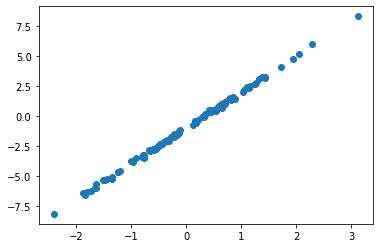

In [18]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys)

因此，我们的模型为：$\hat{y}(x;\theta) = wx +b$。

我们将会用到单个数组，`theta=[w, b]`来装填两个参数：

In [19]:
def model(theta, x):
    """
    Computes wx + b on a batch of input x.
    根据批量输入x来计算 wx+b
    """
    
    w, b = theta
    return w * x + b
    

那么损失函数为 $J(x, y; \theta) = (\hat{y} - y)^2$。

In [20]:
def loss_fn(theta, x, y):
    prediction = model(theta, x)
    return jnp.mean((prediction - y) ** 2)

我们将如何优化损失函数呢？使用梯度下降。在每个更新步骤中，我们将找到相对于参数的损失梯度，并且在最陡的下降方向上走上一小步$\theta_{new} = \theta-0.1(\triangledown_{\theta} J)(x, y; \theta)$：

In [21]:
def update(theta, x, y, lr=0.1):
    return theta - lr * jax.grad(loss_fn)(theta, x, y)

在JAX中，通常会定义一个`update()`函数，该函数将在每个步骤中调用，将当前参数作为输入并返回新参数。这是JAX函数式的自然结果，在[状态的问题]一节中将会有更详细的解释。

之后，我们可以对该函数进行整体的JIT编译，以实现最高效率。下一节将会更加确切地解释`jax.jit`的工作原理，但如果您愿意，您可以尝试在`update()`定义之前添加 `@jax.jit`，并查看下面的训练循环如何更快地运行：

w: 2.98, b: -1.00


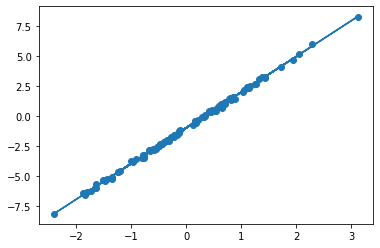

In [22]:
theta = jnp.array([1., 1.])

for _ in range(1000):
    theta = update(theta, xs, ys)
    
plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

正如您阅读时看到这样，这份代码基本就是将在JAX中实现所有训练循环的一个基础。该示例与实际训练循环之间的主要区别在于我们的模型较为简单：这里我们只用单个数组来容纳所有参数。我们将在后面的 `pytree`指南中